<a href="https://colab.research.google.com/github/AlexThirty/XAI_project/blob/main/ResNet_black_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!ls /content/drive/MyDrive/Blackboxes

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

input_shape = (32,32,3)
num_labels = 10

def preprocess_images(images, target_shape=input_shape):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [5]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides=[1,1]):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters[0], padding='same', kernel_size=kernel_size[0], strides=strides[0]
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters[1], padding='same', kernel_size=kernel_size[1], strides=strides[1]
        )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
      Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
      Y = self.bn2(self.conv2(Y))
      Y = Y + X
      return tf.keras.activations.relu(Y)
    
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, channels, kernel_size, strides, residuals, **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(residuals):
            self.residual_layers.append(ResidualBlock(channels, kernel_size, strides))
        
    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

def get_ResNet(residuals, filters, kernel_size, strides):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        ResNetBlock(filters, kernel_size, strides, 2),
        ResNetBlock(filters, kernel_size, strides, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(10),
    ])
        
filters = [64, 32]
kernel_size = [3, 3]
strides = [1,1]

resNet = get_ResNet(2, filters, kernel_size, strides)

resNet.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


Epoch 1/50
1563/1563 [==============================] - 69s 42ms/step - loss: 1.4251 - accuracy: 0.4871 - val_loss: 2.0011 - val_accuracy: 0.4098
Epoch 2/50
1563/1563 [==============================] - 65s 42ms/step - loss: 1.0703 - accuracy: 0.6226 - val_loss: 1.4791 - val_accuracy: 0.4996
Epoch 3/50
1563/1563 [==============================] - 65s 42ms/step - loss: 0.9265 - accuracy: 0.6739 - val_loss: 1.9816 - val_accuracy: 0.4457
Epoch 4/50
1563/1563 [==============================] - 66s 42ms/step - loss: 0.8324 - accuracy: 0.7064 - val_loss: 1.5593 - val_accuracy: 0.5204
Epoch 5/50
1563/1563 [==============================] - 65s 42ms/step - loss: 0.7573 - accuracy: 0.7353 - val_loss: 1.5072 - val_accuracy: 0.5269
Epoch 6/50
1563/1563 [==============================] - 65s 42ms/step - loss: 0.6980 - accuracy: 0.7571 - val_loss: 1.4040 - val_accuracy: 0.5820
Epoch 7/50
1563/1563 [==============================] - 65s 42ms/step - loss: 0.6447 - accuracy: 0.7757 - val_loss: 1.2043 -

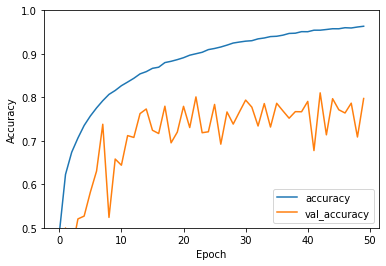

In [6]:
history = resNet.fit(train_images, train_labels, epochs=50,
                     validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = resNet.evaluate(test_images,  test_labels, verbose=2)

In [7]:
resNet.save('/content/drive/MyDrive/Blackboxes/ResNet_black_box')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Blackboxes/ResNet_black_box/assets


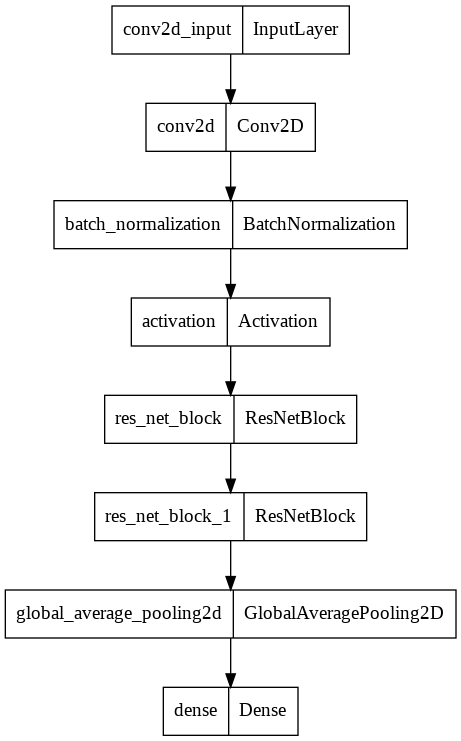

In [8]:
tf.keras.utils.plot_model(resNet, to_file='/content/drive/MyDrive/Blackboxes/ResNet.png')